In [1]:
%config Completer.use_jedi = False

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import theano
import theano.tensor as tt
import scipy
import os
import update_q

import pymc3 as pm
import arviz as az

from glob import glob

In [2]:
age = pd.read_csv('../demo.csv')

In [3]:
glober = '/media/Data/Lab_Projects/Aging/behavioral/Reversal/AG_*_RV/ETLearning_*.csv'

db = pd.DataFrame()

for sub in glob(glober):
    
    try:
        df = pd.read_csv(sub)
        df['sub'] = sub.split('_')[2]
        if df.shape[0] == 70:
            db = pd.concat([db, df], axis = 0)
            #db = db.append(df)#[df.trialNum<36])
    except:
        print(sub)
        print('error')

#db['rating'] = db['rating'].replace(0, np.nan)
db = db.sort_values(by=['sub','trialNum'])
print('number of subject: ', len(db['sub'].unique()))

number of subject:  98


In [4]:
db['sub'] = db['sub'].astype('int')
db = db.merge(age, left_on='sub', right_on='sub')
db = db.sort_values('sub')
print('Valid subjects: ', len(np.unique(db['sub'])))

Valid subjects:  71


In [5]:
x = db[db['RT']==-1].groupby('sub').count()['rating']
x = x[x>5].reset_index()
print(x)
db = db[~db['sub'].isin(x['sub'].values)]

   sub  rating
0  102      13


In [6]:
subs = db.drop_duplicates('sub')
subs = subs.drop(['trialNum', 'rectOri', 'rectValue', 'rating', 'RT'],axis = 1).reset_index(drop=True)
subs.head()

,sub,gender,age,moca_score
0,10,M,18,28
1,11,F,43,26
2,13,F,48,28
3,14,F,26,30
4,15,F,58,26


In [7]:
n_subj   = len(db['sub'].unique())
n_trials = max(db.trialNum)

trials, subj = np.meshgrid(list(range(n_trials)), range(n_subj))
trial = (trials<35)*1
trials = tt.as_tensor_variable(trials.T)
trial = tt.as_tensor_variable(trial.T)
subj   = tt.as_tensor_variable(subj.T)

In [8]:
stim   = np.reshape([db['rectOri']],   (n_subj, n_trials)).T
reward = np.reshape([db['rectValue']], (n_subj, n_trials)).T
rating = np.reshape([db['rating']],    (n_subj, n_trials)).T
rating = [np.nan if 0 else x/9 for x in rating]

stim   = np.array(stim/45,  dtype='int')
reward = np.array(reward/6, dtype='int')

In [9]:
stim = tt.as_tensor_variable(stim)
reward = tt.as_tensor_variable(reward)

In [10]:
ageT = np.reshape([db['age']],   (n_subj, n_trials)).T
ageT = np.array(ageT/100,  dtype='int')
ageT = tt.as_tensor_variable(ageT)

In [11]:
tune = 2000 # 2000
draws = 2000
target_accept = .95 #.99

In [12]:
with pm.Model() as model_RW_H:
    
    mu = pm.Normal('mu', 0, 1)
    sd = pm.HalfNormal('sd',2) 
    intercept = pm.Normal('intercept', mu, sd, shape=n_subj)
    
    beta_h = pm.Normal('beta_h', 0,1)
    beta_sd = pm.HalfNormal('beta_sd', 1)
    beta = pm.Normal('beta',beta_h, beta_sd, shape=n_subj)
    
    eps = pm.HalfNormal('eps', 5)
    
    a_a = pm.TruncatedNormal('a_a', 3, 2, lower=1)
    a_b = pm.TruncatedNormal('a_b', 7, 2, lower=1)

    alpha = pm.Beta('alpha', a_a, a_b, shape=n_subj)
    
    
    Qs = .5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = .5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_q.update_Q,
        sequences=[stim, reward],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = vec[trials,subj,0] * beta[subj] + intercept[subj]
    
    learn = pm.Normal('learn', vec_, eps, observed=rating) 
    
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    
    trace_RW_h = pm.sample(tune=tune, draws=draws, return_inferencedata=True, target_accept= target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, a_b, a_a, eps, beta, beta_sd, beta_h, intercept, sd, mu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1545 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [13]:
with pm.Model() as model_RW_valence_H:
    
    mu = pm.Normal('mu', 0, 1)
    sd = pm.HalfNormal('sd',5) 
    intercept = pm.Normal('intercept', mu, sd, shape=n_subj)
     
    beta_h = pm.Normal('beta_h', 0,1)
    beta_sd = pm.HalfNormal('beta_sd', 1)
    beta = pm.Normal('beta',beta_h, beta_sd, shape=n_subj)
    
    eps = pm.HalfNormal('eps', 5)
    
    ap_a = pm.TruncatedNormal('ap_a', 3, 2, lower=1)
    ap_b = pm.TruncatedNormal('ap_b', 7, 2, lower=1)
    
    an_a = pm.TruncatedNormal('an_a', 3, 2, lower=1)
    an_b = pm.TruncatedNormal('an_b', 7, 2, lower=1)

    alpha_p = pm.Beta('alpha_p', ap_a, ap_b, shape=n_subj)
    alpha_n = pm.Beta('alpha_n', an_a, an_b, shape=n_subj)
    
    
    Qs = .5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = .5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_q.update_Q_valence,
        sequences=[stim, reward],
        outputs_info=[Qs, vec],
        non_sequences=[alpha_p, alpha_n, n_subj])
   
    
    vec_ = vec[trials,subj,0] * beta[subj] + intercept[subj]
    
    learn = pm.Normal('learn', vec_, eps, observed=rating) 
    
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    
    trace_RW_valence_h = pm.sample(tune=tune, draws=draws, return_inferencedata=True, target_accept= target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_n, alpha_p, an_b, an_a, ap_b, ap_a, eps, beta, beta_sd, beta_h, intercept, sd, mu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2471 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [15]:
with pm.Model() as model_RW_halves_h:
    
    mu = pm.Normal('mu', 0, 1)
    sd = pm.HalfNormal('sd',1) 
    intercept = pm.Normal('intercept', mu, sd, shape=n_subj)
    
    beta_h = pm.Normal('beta_h', 0,1)
    beta_sd = pm.HalfNormal('beta_sd', 1)
    beta = pm.Normal('beta',beta_h, beta_sd, shape=n_subj)
    
    a_a1 = pm.TruncatedNormal('a_a1', 3, 1, lower=1)
    a_b1 = pm.TruncatedNormal('a_b1', 8, 2, lower=1)
    
    a_a2 = pm.TruncatedNormal('a_a2', 3, 1, lower=1)
    a_b2 = pm.TruncatedNormal('a_b2', 8, 2, lower=1)


    alpha_1 = pm.Beta('alpha_1', a_a1, a_b1, shape=n_subj)
    alpha_2 = pm.Beta('alpha_2', a_a2, a_b2, shape=n_subj)
    
    eps = pm.HalfNormal('eps', 5)
    
    Qs = .5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = .5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_q.update_Q_half,
        sequences=[stim, reward, trial],
        outputs_info=[Qs, vec],
        non_sequences=[alpha_1, alpha_2,  n_subj])
   
    
    vec_ = vec[trials,subj,0] * beta[subj] + intercept[subj]
    
    learn = pm.Normal('learn', vec_, eps, observed=rating) 
    
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    
    trace_RW_halves_h = pm.sample(tune=tune, draws=draws, return_inferencedata=True, target_accept= target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, alpha_2, alpha_1, a_b2, a_a2, a_b1, a_a1, beta, beta_sd, beta_h, intercept, sd, mu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2625 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [31]:
with pm.Model() as model_RW_valence_halves:
    
    mu = pm.Normal('mu', 0, 1)
    sd = pm.HalfNormal('sd',1) 
    intercept = pm.Normal('intercept', mu, sd, shape=n_subj)
    
    beta_h = pm.Normal('beta_h', 0,1)
    beta_sd = pm.HalfNormal('beta_sd', 1)
    beta = pm.Normal('beta',beta_h, beta_sd, shape=n_subj)
    
    ap_a1 = pm.TruncatedNormal('ap_a1', 3, 1, lower=1)
    ap_b1 = pm.TruncatedNormal('ap_b1', 8, 2, lower=1)
    
    ap_a2 = pm.TruncatedNormal('ap_a2', 3, 1, lower=1)
    ap_b2 = pm.TruncatedNormal('ap_b2', 8, 2, lower=1)
    
    an_a1 = pm.TruncatedNormal('an_a1', 3, 1, lower=1)
    an_b1 = pm.TruncatedNormal('an_b1', 8, 2, lower=1)
    
    an_a2 = pm.TruncatedNormal('an_a2', 3, 1, lower=1)
    an_b2 = pm.TruncatedNormal('an_b2', 8, 2, lower=1)

    alphap_1 = pm.Beta('alphap_1', ap_a1, ap_b1, shape=n_subj)
    alphap_2 = pm.Beta('alphap_2', ap_a2, ap_b2, shape=n_subj)
    alphan_1 = pm.Beta('alphan_1', an_a1, an_b1, shape=n_subj)
    alphan_2 = pm.Beta('alphan_2', an_a2, an_b2, shape=n_subj)
    
    eps = pm.HalfNormal('eps', 5)
    
    Qs = .5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = .5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_q.update_Q_valence_half,
        sequences=[stim, reward, trial],
        outputs_info=[Qs, vec],
        non_sequences=[alphap_1, alphan_1, alphap_2, alphan_2,  n_subj])
   
    
    vec_ = vec[trials,subj,0] * beta[subj] + intercept[subj]
    
    learn = pm.Normal('learn', vec_, eps, observed=rating) 
    
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    
    trace_RW_valence_halves_h = pm.sample(tune=tune, draws=draws, return_inferencedata=True, target_accept= target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, alphan_2, alphan_1, alphap_2, alphap_1, an_b2, an_a2, an_b1, an_a1, ap_b2, ap_a2, ap_b1, ap_a1, beta, beta_sd, beta_h, intercept, sd, mu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3867 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [14]:
with pm.Model() as model_RW_decay_H:
    
    mu = pm.Normal('mu', 0, 1)
    sd = pm.HalfNormal('sd',1) 
    intercept = pm.Normal('intercept', mu, sd, shape=n_subj)
    
    beta_h = pm.Normal('beta_h', 0,1)
    beta_sd = pm.HalfNormal('beta_sd', 1)
    beta = pm.Normal('beta',beta_h, beta_sd, shape=n_subj)
    
    eps = pm.HalfNormal('eps', 5)
    
    a_a = pm.TruncatedNormal('a_a', 3, 1, lower=1)
    a_b = pm.TruncatedNormal('a_b', 8, 2, lower=1)

    alpha = pm.Beta('alpha', a_a, a_b, shape=n_subj)
    
    decay_a = pm.TruncatedNormal('decay_a', 5, 2, lower=1)
    decay_b = pm.TruncatedNormal('decay_b', 5, 2, lower=1)
    
    decay = pm.Beta('decay', decay_a, decay_b, shape=n_subj)
    
    Qs = .5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = .5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_q.update_Q_decay,
        sequences=[stim, reward],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, decay, n_subj])
   
    
    vec_ = vec[trials,subj,0] * beta[subj] + intercept[subj]
    
    learn = pm.Normal('learn', vec_, eps, observed=rating) 
    
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    
    trace_RW_decay_h = pm.sample(tune=tune, draws=draws, return_inferencedata=True, target_accept= .99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [decay, decay_b, decay_a, alpha, a_b, a_a, eps, beta, beta_sd, beta_h, intercept, sd, mu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 8730 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [16]:
with pm.Model() as model_PH_h:
    
    # Hyper priors
    mu = pm.Normal('mu', 0, 1)
    sd = pm.HalfNormal('sd',1) 
    intercept = pm.Normal('intercept', mu, sd, shape=n_subj)
    
    beta_h = pm.Normal('beta_h', 0,1)
    beta_sd = pm.HalfNormal('beta_sd', .1)
    beta = pm.Normal('beta',beta_h, beta_sd, shape=n_subj)
    
    
    eta_a = pm.TruncatedNormal('eta_a', 3, 1, lower=1)
    eta_b = pm.TruncatedNormal('eta_b', 8, 2, lower=1)
    
    kappa_a = pm.TruncatedNormal('kappa_a', 8, 2, lower=1)
    kappa_b = pm.TruncatedNormal('kappa_b', 3, 1, lower=1)
      
    eta = pm.Beta('eta', eta_a, eta_b, shape=n_subj)
    kappa = pm.Beta('kappa', kappa_a, kappa_b, shape=n_subj)

    
    eps = pm.HalfNormal('eps', 5)
    
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    alpha = 0 * tt.ones((n_subj,2), dtype='float64') # vector to save the relevant stimulus's expactation
    assoc = 0 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec, alpha, assoc], updates = theano.scan(
        fn=update_q.update_Q_hall,
        sequences=[stim, reward],
        outputs_info=[Qs, vec, alpha, assoc],
        non_sequences=[eta, kappa, n_subj])
    
    vec_ = vec[trials, subj,0] * beta[subj] + intercept[subj]
    
    learn = pm.Normal('learn', mu = vec_, sd = eps, observed=rating) 
    
    ev = pm.Deterministic('expected_value', vec_)
    
    trace_PH_h = pm.sample(tune=tune, draws=draws, return_inferencedata=True, target_accept= .99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, kappa, eta, kappa_b, kappa_a, eta_b, eta_a, beta, beta_sd, beta_h, intercept, sd, mu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 15865 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [32]:
models = {'RW': trace_RW_h, 
          'RW valence': trace_RW_valence_h,
          'RW halves':trace_RW_halves_h,
          'RW valence halves': trace_RW_valence_h,
          'RW decay':trace_RW_valence_halves_h, 
          'PH': trace_PH_h}

comp = az.compare(models)
az.compare(models, ic='loo')

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
RW valence halves,0,-519.644522,141.946154,0.000000,5.863039e-01,41.355722,0.000000,False,log
RW halves,1,-531.741088,140.585150,12.096566,4.136961e-01,41.144829,12.639943,False,log
RW,2,-595.453611,95.213203,75.809088,0.000000e+00,39.533995,11.135869,False,log
PH,3,-602.906095,81.079481,83.261573,0.000000e+00,39.378260,12.010881,False,log
RW decay,4,-606.331563,85.985635,86.687040,1.949552e-13,39.412341,12.306622,False,log


<AxesSubplot:xlabel='Log'>

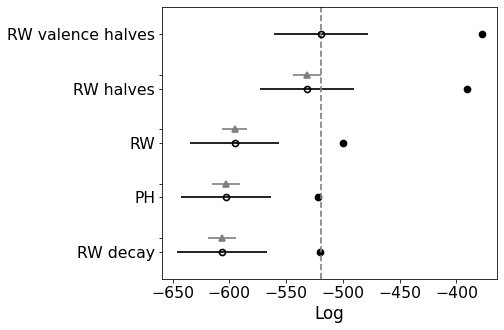

In [33]:
az.plot_compare(comp)

<AxesSubplot:xlabel='Log'>

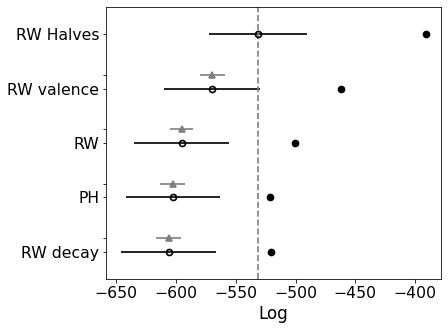

In [19]:
az.plot_compare(comp) #old

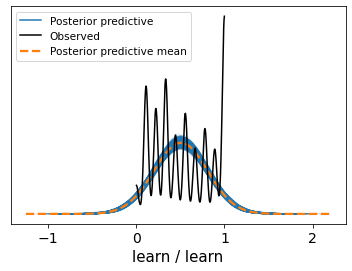

In [20]:
with model_RW_halves_h:
    ppc = pm.sample_posterior_predictive(
        trace_RW_halves_h)
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model_RW_halves_h));

In [35]:
df = db[['sub','age', 'gender', 'moca_score']].sort_values('sub').drop_duplicates().reset_index(drop=True)
df['age'] = df.age.astype('int')


In [37]:
alphap_1 = az.summary(trace_RW_valence_halves_h, var_names=['alphap_1'])[['mean']]
alphap_2 = az.summary(trace_RW_valence_halves_h, var_names=['alphap_2'])[['mean']]
alphan_1 = az.summary(trace_RW_valence_halves_h, var_names=['alphan_1'])[['mean']]
alphan_2 = az.summary(trace_RW_valence_halves_h, var_names=['alphan_2'])[['mean']]

alphap_1 = alphap_1.rename(columns={'mean': "alphap_1"}).reset_index(drop=True)
alphap_2 = alphap_2.rename(columns={'mean': "alphap_2"}).reset_index(drop=True)
alphan_1 = alphan_1.rename(columns={'mean': "alphan_1"}).reset_index(drop=True)
alphan_2 = alphan_2.rename(columns={'mean': "alphan_2"}).reset_index(drop=True)

df = df.merge(alphap_1, left_index=True, right_index=True)
df = df.merge(alphap_2, left_index=True, right_index=True)
df = df.merge(alphan_1, left_index=True, right_index=True)
df = df.merge(alphan_2, left_index=True, right_index=True)

df.head()

,sub,age,gender,moca_score,alphap_1,alphap_2,alphan_1,alphan_2
0,10,18,M,28,0.124,0.385,0.261,0.115
1,11,43,F,26,0.331,0.473,0.196,0.053
2,13,48,F,28,0.126,0.438,0.253,0.093
3,14,26,F,30,0.151,0.432,0.259,0.117
4,15,58,F,26,0.139,0.496,0.240,0.126


In [38]:
ap1_trace = corr(pd.DataFrame({'x': df.age/100, 'y': df.alphap_1}).reset_index(drop=True))
ap2_trace = corr(pd.DataFrame({'x': df.age/100, 'y': df.alphap_2}).reset_index(drop=True))
an1_trace = corr(pd.DataFrame({'x': df.age/100, 'y': df.alphan_1}).reset_index(drop=True))
an2_trace = corr(pd.DataFrame({'x': df.age/100, 'y': df.alphan_2}).reset_index(drop=True))

ap1 = az.summary(ap1_trace, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]
ap2 = az.summary(ap2_trace, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]
an1 = az.summary(an1_trace, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]
an2 = az.summary(an2_trace, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, eps, slope, intercept]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 8 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, eps, slope, intercept]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 8 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, eps, slope, intercept]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 9 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, eps, slope, intercept]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 7 seconds.


/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result i

Text(20, 0.2, 'β = 0.02,\n89% HDPi [0.00, 0.03]')

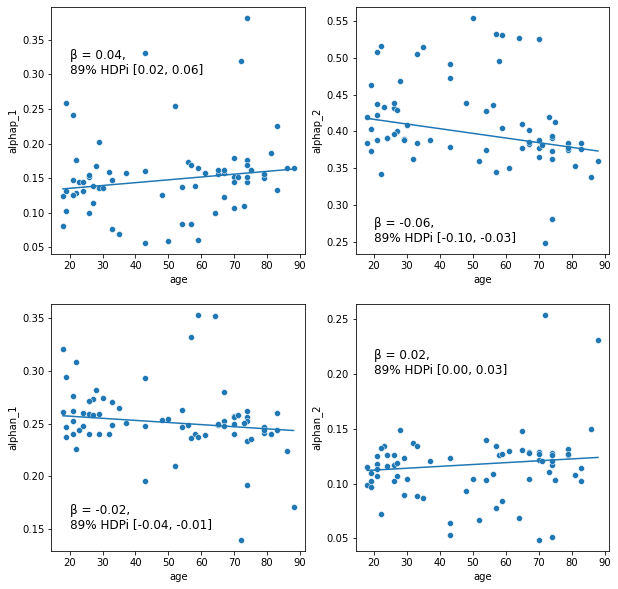

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
sns.scatterplot(y = 'alphap_1',  x = 'age', data=df, ax=axes[0,0])
sns.scatterplot(y = 'alphap_2', x = 'age', data=df, ax=axes[0,1])
sns.scatterplot(y = 'alphan_1', x = 'age', data=df, ax=axes[1,0])
sns.scatterplot(y = 'alphan_2', x = 'age', data=df, ax=axes[1,1])


sns.lineplot(df.age,ap1['mean']['intercept']+ap1['mean']['slope']*df.age/100, ax=axes[0,0])
sns.lineplot(df.age,ap2['mean']['intercept']+ap2['mean']['slope']*df.age/100, ax=axes[0,1])
sns.lineplot(df.age,an1['mean']['intercept']+an1['mean']['slope']*df.age/100, ax=axes[1,0])
sns.lineplot(df.age,an2['mean']['intercept']+an2['mean']['slope']*df.age/100, ax=axes[1,1])

#axes[0].set(ylim=(0,1))
#axes[1].set(ylim=(0,1))
#axes[2].set(ylim=(0,1))


text = 'β = {:.2f},\n89% HDPi [{:.2f}, {:.2f}]'.format(float(ap1['mean']['slope']),
                                                        float(ap1['hdi_5.5%']['slope']),
                                                        float(ap1['hdi_94.5%']['slope']))
axes[0,0].text(20, .3, text, fontsize=12)

text = 'β = {:.2f},\n89% HDPi [{:.2f}, {:.2f}]'.format(float(ap2['mean']['slope']),
                                                        float(ap2['hdi_5.5%']['slope']),
                                                        float(ap2['hdi_94.5%']['slope']))
axes[0,1].text(20, .25, text, fontsize=12)

text = 'β = {:.2f},\n89% HDPi [{:.2f}, {:.2f}]'.format(float(an1['mean']['slope']),
                                                        float(an1['hdi_5.5%']['slope']),
                                                        float(an1['hdi_94.5%']['slope']))
axes[1,0].text(20, .15, text, fontsize=12)

text = 'β = {:.2f},\n89% HDPi [{:.2f}, {:.2f}]'.format(float(an2['mean']['slope']),
                                                        float(an2['hdi_5.5%']['slope']),
                                                        float(an2['hdi_94.5%']['slope']))
axes[1,1].text(20, .2, text, fontsize=12)

In [ ]:
trace_RW_valence_halves_h

In [22]:
alpha_1 = az.summary(trace_RW_halves_h, var_names=['alpha_1'])[['mean']]
alpha_2 = az.summary(trace_RW_halves_h, var_names=['alpha_2'])[['mean']]

alpha_1 = alpha_1.rename(columns={'mean': "alpha_1"}).reset_index(drop=True)
alpha_2 = alpha_2.rename(columns={'mean': "alpha_2"}).reset_index(drop=True)

df = df.merge(alpha_1, left_index=True, right_index=True)
df = df.merge(alpha_2, left_index=True, right_index=True)

df.head()

,sub,age,gender,moca_score,alpha_1,alpha_2
0,10,18,M,28,0.271,0.047
1,11,43,F,26,0.352,0.066
2,13,48,F,28,0.253,0.084
3,14,26,F,30,0.256,0.123
4,15,58,F,26,0.254,0.091


In [23]:
def corr(df):
    with pm.Model() as RR:

        a = pm.Normal('intercept', 0, 1)
        b = pm.Normal('slope', 0, 1)
        eps = pm.Exponential('eps', 1)
        y_hat = a + b*df.x

        nu = pm.InverseGamma("nu", alpha=3, beta=1)

        #likelihood = pm.Normal("likelihood", mu=y_hat, sigma=eps, observed=y)

        likelihood = pm.StudentT(
            "likelihood", mu=y_hat, sigma=eps, nu=nu, observed=df.y
        )

        trace_robust = pm.sample(tune=3000, draws=1000, return_inferencedata=True, target_accept=0.95)
        
    return(trace_robust)

In [24]:
a1_trace = corr(pd.DataFrame({'x': df.age/100, 'y': df.alpha_1}).reset_index(drop=True))
a2_trace = corr(pd.DataFrame({'x': df.age/100, 'y': df.alpha_2}).reset_index(drop=True))

a1 = az.summary(a1_trace, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]
a2 = az.summary(a2_trace, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, eps, slope, intercept]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 9 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, eps, slope, intercept]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 8 seconds.


/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(18, 0.02, 'β = -0.01,\n89% HDPi [-0.03, 0.02]')

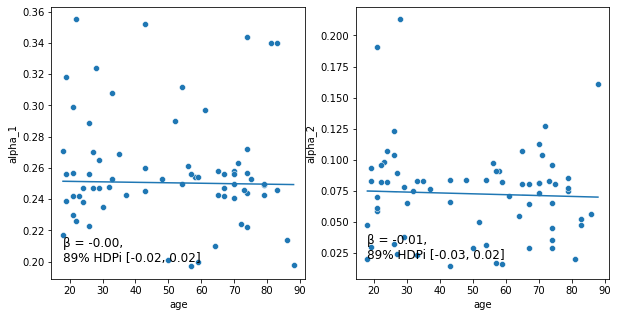

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(y = 'alpha_1', x = 'age', data=df, ax=axes[0])
sns.scatterplot(y = 'alpha_2', x = 'age', data=df, ax=axes[1])

sns.lineplot(df.age,a1['mean']['intercept']+a1['mean']['slope']*df.age/100, ax=axes[0])
sns.lineplot(df.age,a2['mean']['intercept']+a2['mean']['slope']*df.age/100, ax=axes[1])

# axes[0].set(ylim=(-4.5,6.5))
# axes[1].set(ylim=(-4.5,6.5))


text = 'β = {:.2f},\n89% HDPi [{:.2f}, {:.2f}]'.format(float(a1['mean']['slope']),
                                                       float(a1['hdi_5.5%']['slope']),
                                                       float(a1['hdi_94.5%']['slope']))
axes[0].text(18, .2, text, fontsize=12)

text = 'β = {:.2f},\n89% HDPi [{:.2f}, {:.2f}]'.format(float(a2['mean']['slope']),
                                                       float(a2['hdi_5.5%']['slope']),
                                                       float(a2['hdi_94.5%']['slope']))
axes[1].text(18, .02, text, fontsize=12)




In [41]:
df.to_csv('data/reversal_model_results.csv')

In [42]:
trace_RW_valence_h.to_netcdf("data/RW_vh_h.nc")

'data/RW_vh_h.nc'

In [43]:
db.to_csv('data/db_trials.csv')